In [28]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [29]:
import torch

if torch.cuda.is_available():
  dev = "cuda"
else:
  dev = "cpu"
device = torch.device(dev)

print(device)

cuda


In [30]:
torch.cuda.is_available()

True

In [31]:
print(torch.__version__)

2.1.2


In [32]:
import pickle

with open('aligned_paragraph_dataset.pickle', 'rb') as fp:
  aligned_paragraph_dataset = pickle.load(fp)

with open('source_paragraph_dataset.pickle', 'rb') as fp:
  source_paragraph_dataset = pickle.load(fp)

In [33]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/kkatsy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [34]:
min_paragraph_len = 40
max_paragraph_len = int(512)

In [35]:
# create dict: translator to books
# NotesFromUnderground - Katz, PV, Garnett
# PoorFolk - McDuff, Hogarth, Garnett

# format: label->translator, x->source+translation
# dict: key-> translator, value: list of {source:s, translation:t, index:i}
translator_to_pars = {}
translator_to_pars_holdout = {}

# Holdout
# NotesFromUnderground - Katz, PV, Garnett
# PoorFolk - McDuff, Hogarth, Garnett
holdout_books = ['PoorFolk', 'NotesFromUnderground']

translator_to_pars = {}
translator_to_pars_holdout = {}

# for each book in train:
for book in sorted(list(aligned_paragraph_dataset.keys())):
    # get par list of aligned sentences, best k alignments
    book_par_list = [list(aligned_paragraph_dataset[book][p].values()) for p in range(len(aligned_paragraph_dataset[book]))]

    for i in range(len(book_par_list)):
        par_trans_dict = aligned_paragraph_dataset[book][i]
        par_source = source_paragraph_dataset[book][i]

        par_set = list(par_trans_dict.values())

        max_par_len = len(max(par_set, key = len))
        min_par_len = len(min(par_set, key = len))

        if (min_par_len >= min_paragraph_len) and (max_par_len) <= max_paragraph_len and not all(x==par_set[0] for x in par_set):

            for translator, t in par_trans_dict.items():
                datum_dict = {'source':par_source, 'translation': t, 'idx': i, 'book': book}

                if translator not in translator_to_pars.keys():
                    translator_to_pars[translator] = []
                    translator_to_pars_holdout[translator] = []
                    
                if book in holdout_books:
                    translator_to_pars_holdout[translator].append(datum_dict)
                else:
                    translator_to_pars[translator].append(datum_dict)

In [36]:
translator_to_pars['PV'][:5]

[{'source': 'Все счастливые семьи похожи друг на друга, каждая несчастливая семья несчастлива по-своему.',
  'translation': 'All happy families are alike; each unhappy family is unhappy in its own way.',
  'idx': 3,
  'book': 'AnnaKarenina'},
 {'source': '«Да, да, как это было? – думал он, вспоминая сон. – Да, как это было? Да! Алабин давал обед в Дармштадте; нет, не в Дармштадте, а что-то американское. Да, но там Дармштадт был в Америке. Да, Алабин давал обед на стеклянных столах, да, – и столы пели: Il mio tesoro и не Il mio tesoro,[32] а что-то лучше, и какие-то маленькие графинчики, и они же женщины», – вспоминал он.',
  'translation': '"Yes, yes, how did it go?\' he thought, recalling his dream. \'How did it go? Yes! Alabin was giving a dinner in Darmstadt-no, not in Darmstadt but something American. Yes, but this Darmstadt was in America. Yes, Alabin was giving a dinner on glass tables, yes - and the tables were singing II mio tesoro,1 only it wasn\'t II mio tesoro but something 

In [37]:
total = 0
print('Train')
for k in translator_to_pars.keys():
    print(k, len(translator_to_pars[k]))
    total += len(translator_to_pars[k])
print('Total', total)

total = 0
print('\nHoldout')
for k in translator_to_pars_holdout.keys():
    print(k, len(translator_to_pars_holdout[k]))
    total += len(translator_to_pars_holdout[k])
print('Total', total)

Train
PV 19086
Garnett 19086
Katz 5380
McDuff 8386
Hogarth 2752
Total 54690

Holdout
PV 310
Garnett 362
Katz 310
McDuff 52
Hogarth 52
Total 1086


In [38]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(list(translator_to_pars.keys()))
print(le.transform(["Garnett", "McDuff", "PV", "Katz", "Hogarth"]))

[0 3 4 2 1]


In [39]:
data_list = []
i = 0
for tr in translator_to_pars.keys():
    label = le.transform([tr])[0]
    for d in translator_to_pars[tr]:
        src, trn = d['source'], d['translation']
        s = trn
        sent_dict = {'idx': d['idx'], 'book':d['book'], 'labels': label, 'sentence': s}
        data_list.append(sent_dict)
        i += 1


data_list_holdout = []
i = 0
for tr in translator_to_pars_holdout.keys():
    label = le.transform([tr])[0]
    for d in translator_to_pars_holdout[tr]:
        src, trn = d['source'], d['translation']
        s = trn
        sent_dict = {'idx': d['idx'], 'book':d['book'], 'labels': label, 'sentence': s}
        data_list_holdout.append(sent_dict)
        i += 1
        
print(data_list[:10])

[{'idx': 3, 'book': 'AnnaKarenina', 'labels': 4, 'sentence': 'All happy families are alike; each unhappy family is unhappy in its own way.'}, {'idx': 6, 'book': 'AnnaKarenina', 'labels': 4, 'sentence': '"Yes, yes, how did it go?\' he thought, recalling his dream. \'How did it go? Yes! Alabin was giving a dinner in Darmstadt-no, not in Darmstadt but something American. Yes, but this Darmstadt was in America. Yes, Alabin was giving a dinner on glass tables, yes - and the tables were singing II mio tesoro,1 only it wasn\'t II mio tesoro but something better, and there were some little carafes, which were also women,\' he recalled.'}, {'idx': 8, 'book': 'AnnaKarenina', 'labels': 4, 'sentence': '\'Oh, oh, oh! Ohh!.." he moaned, remembering all that had taken place. And in his imagination he again pictured all the details of his quarrel with his wife, all the hopelessness of his position and, most painful of all, his own guilt.'}, {'idx': 9, 'book': 'AnnaKarenina', 'labels': 4, 'sentence': "

In [40]:
import pandas as pd

df = pd.DataFrame(data_list)
df_holdout = pd.DataFrame(data_list_holdout)
df.head()

,idx,book,labels,sentence
0,3,AnnaKarenina,4,All happy families are alike; each unhappy fam...
1,6,AnnaKarenina,4,"""Yes, yes, how did it go?' he thought, recalli..."
2,8,AnnaKarenina,4,"'Oh, oh, oh! Ohh!.."" he moaned, remembering al..."
3,9,AnnaKarenina,4,"'No, she won't forgive me and can't forgive me..."
4,10,AnnaKarenina,4,"Worst of all had been that first moment when, ..."


In [41]:
# from sklearn.utils import shuffle
# df = shuffle(df)
# df = df.head(100000)
df.shape
df_holdout.shape

(1086, 4)

In [42]:
from sklearn.model_selection import train_test_split

# train_texts = df['sentence'].values.tolist()
# train_labels = df['labels'].values.tolist()
test_texts = df_holdout['sentence'].values.tolist()
test_labels = df_holdout['labels'].values.tolist()

train_texts, _, train_labels, _ = train_test_split(
    df['sentence'].values.tolist(), df['labels'].values.tolist(),
    stratify = df['labels'], train_size=0.55, shuffle=True
)

print('train size: ', len(list(train_labels)))
print('test size: ', len(list(test_labels)))

sentences = {}
sentences['train'] = []
sentences['test'] = []
for t, l in zip(train_texts, train_labels):
    datum = {'label': l, 'text': t}
    sentences['train'].append(datum)
for t, l in zip(test_texts, test_labels):
    datum = {'label': l, 'text': t}
    sentences['test'].append(datum)

print(sentences['train'][4])

train size:  30079
test size:  1086
{'label': 2, 'text': '"In blessing, you have blessed yourself; sit beside me. Where be you from?"'}


In [43]:
BERT_MODEL = "bert-base-multilingual-cased"

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

In [44]:
import datasets

train_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=sentences['train']))
test_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=sentences['test']))

In [45]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/30079 [00:00<?, ? examples/s]

Map:   0%|          | 0/1086 [00:00<?, ? examples/s]

In [46]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [47]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [48]:
label_list = translator_to_pars.keys()
id_list = le.transform(list(label_list))

id2label = {}
label2id = {}
for l, i in zip(label_list, id_list):
    id2label[i] = l
    label2id[l] = i

print(id2label)
print(label2id)

{4: 'PV', 0: 'Garnett', 2: 'Katz', 3: 'McDuff', 1: 'Hogarth'}
{'PV': 4, 'Garnett': 0, 'Katz': 2, 'McDuff': 3, 'Hogarth': 1}


In [49]:
fine_tune = True

In [50]:
from numpy import mean
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# device (turn on GPU acceleration for faster execution)
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

if fine_tune:
    # model
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels = len(translator_to_pars.keys()))
    model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
device

device(type='cuda')

In [52]:
lr = 2e-5
epochs = 10
batch_size = 16

In [53]:
import wandb

run = wandb.init(
        # Set the project where this run will be logged
        project="translator-classification",
        # Track hyperparameters and run metadata
        config={
            "learning_rate": lr,
            "epochs": epochs,
        },
    )

os.environ["WANDB_PROJECT"]="translator-classification"
os.environ["WANDB_NOTEBOOK_NAME"]="translator_classification"


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [54]:
if fine_tune:
    training_args = TrainingArguments(
        output_dir="/trunk/kkatsy/baseline_10epochs_holdout_512tok",
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        push_to_hub=False,
        report_to="wandb"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [55]:
if fine_tune:
    trainer.train()

/home/kkatsy/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.960300,1.256667,0.511971
2,0.561200,1.235808,0.549724
3,0.407900,1.333000,0.558932
4,0.298300,1.277812,0.593923
5,0.220700,1.566017,0.591160
6,0.164300,1.693921,0.582873
7,0.123400,1.977303,0.583794
8,0.095800,2.292737,0.596685
9,0.068000,2.489751,0.601289
10,0.049800,2.661488,0.597606


/home/kkatsy/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/kkatsy/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/kkatsy/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/kkatsy/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, bu

In [56]:
if fine_tune:
    trainer.evaluate()
    wandb.finish()

/home/kkatsy/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,▁▄▅▇▇▇▇███▄
eval/loss,▁▁▁▁▃▃▅▆▇█▁
eval/runtime,▁▂▁▃▆▂█▄▂▁▃
eval/samples_per_second,█▇█▆▃▇▁▅▇█▆
eval/steps_per_second,█▇█▆▃▇▁▅▇█▆
train/epoch,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇████
train/learning_rate,██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
train/loss,█▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁


In [57]:
# import gc

# del model
# gc.collect()
# torch.cuda.empty_cache()

In [71]:
load_tuned = True

In [72]:
if load_tuned:
    model = AutoModelForSequenceClassification.from_pretrained("/trunk/kkatsy/baseline_10epochs_holdout_512tok/checkpoint-8460")
    model.to(device)


In [73]:
if load_tuned:
    training_args = TrainingArguments(
        output_dir="/trunk/kkatsy/baseline_10epochs_holdout_250tok/checkpoint-4242",
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        push_to_hub=False,
        report_to="wandb"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [74]:
# if load_tuned:
#     trainer.evaluate()

In [75]:
predictions, labels, metrics = trainer.predict(tokenized_test, metric_key_prefix="predict")

/home/kkatsy/anaconda3/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [76]:
predictions

array([[-2.502633  , -2.791699  , -0.9110549 , -1.9696928 ,  7.6940985 ],
       [-1.7236991 , -2.3131213 , -2.0964725 , -1.9259871 ,  7.499305  ],
       [-3.1109393 , -2.8573523 , -0.69998205, -1.5219406 ,  7.4789557 ],
       ...,
       [-2.021502  ,  7.5031133 , -0.6547106 , -1.1114612 , -2.3207781 ],
       [ 6.194398  , -1.8465953 , -0.91479325, -1.6613958 , -1.4082615 ],
       [ 2.7510371 , -2.1772165 , -3.2809205 , -2.8588402 ,  5.314115  ]],
      dtype=float32)

In [77]:
preds = np.argmax(predictions, axis=-1)

In [78]:
translators = [id2label[l] for l in preds]

pred_count = {}
for i in label2id.keys():
    count = translators.count(i)
    pred_count[i] = count

pred_count

{'PV': 401, 'Garnett': 413, 'Katz': 219, 'McDuff': 35, 'Hogarth': 18}

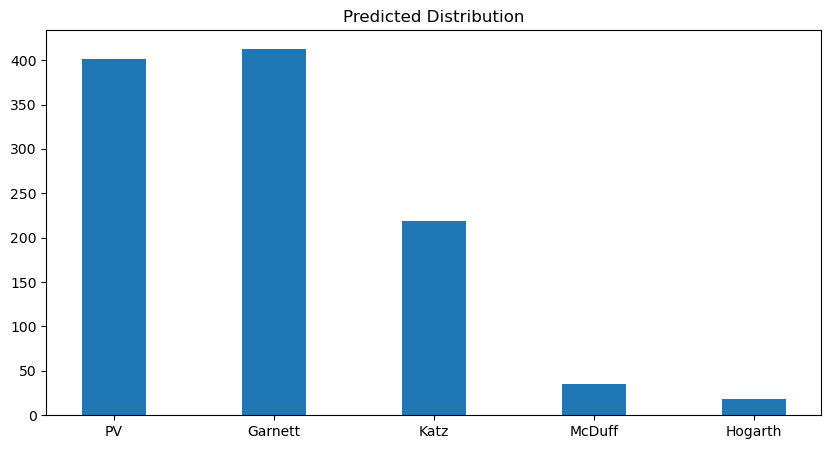

In [79]:
import matplotlib.pyplot as plt


courses = list(pred_count.keys())
values = list(pred_count.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, width = 0.4)
plt.title("Predicted Distribution")
plt.show()

In [80]:
true_count = {}
for i in id2label.keys():
    count = test_labels.count(i)
    true_count[id2label[i]] = count

true_count

{'PV': 310, 'Garnett': 362, 'Katz': 310, 'McDuff': 52, 'Hogarth': 52}

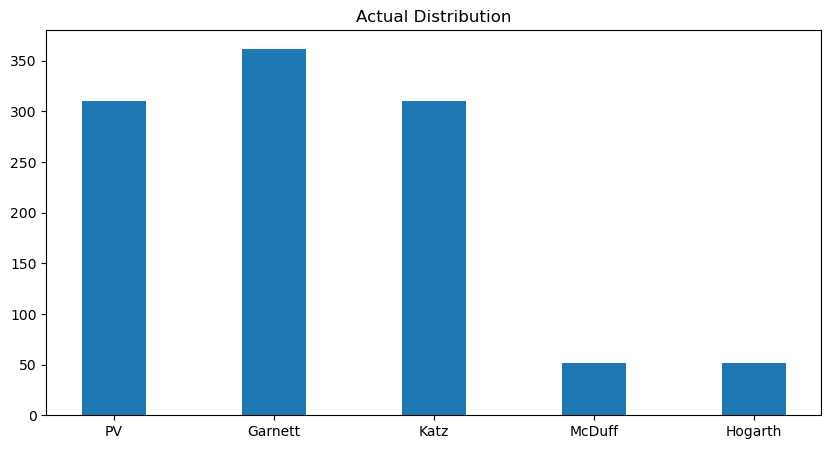

In [81]:
courses = list(true_count.keys())
values = list(true_count.values())
  
fig2 = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, width = 0.4)
plt.title("Actual Distribution")
plt.show()

Accuracy:  0.6012891344383057


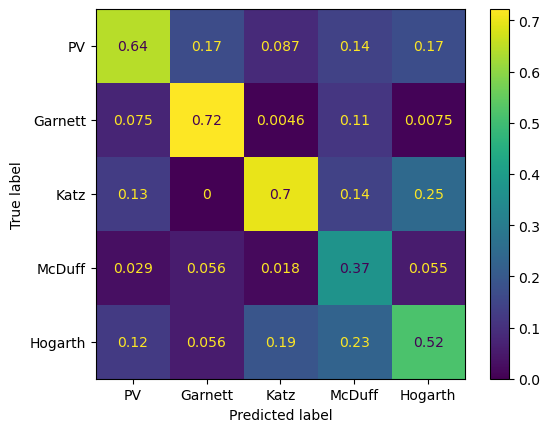

In [82]:
# confusion matrix
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

acc = metrics.accuracy_score(labels, preds)
print('Accuracy: ', acc)

confusion_matrix = metrics.confusion_matrix(labels, preds, normalize='pred')

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=label2id)
cm_display.plot()
plt.show()